# Data assimilation in neXtSIM-DG with NEDAS
Authors: Yue (Michael) Ying (NERSC), Ali Aydogdu (CMCC), Yumeng Chen (U. Reading)

Data assimilation combines information from model forecasts and observations to obtain the best estimate of model state and parameters.

In this tutorial, we show how DA works for neXtSIM-DG in an Observing System Simulation Experiment (OSSE):

- Synthetic observations are simulated from a truth run
- An ensemble forecast with perturbed boundary forcing is run
- The observations are assimilated to reduce errors in the model states.
- The errors in model states are diagnosed against the truth.

This is a rather idealized setting, using very small ensemble size, low model resolution and short test time period.
Real practice is of course more complex than this small demo.

Learn more about NEDAS: [Documentation](https://nedas.readthedocs.io/en/latest/)

## Environment and configuration

A YAML file `config.yml` contains all the settings for an experiment.

See [Configuration file](https://nedas.readthedocs.io/en/latest/config_file.html) documentation for more details.

To run the experiment in command line: `python -m NEDAS -c config.yml`

In [1]:
# load necessary modules
import os
import sys

import numpy as np
from datetime import datetime, timedelta, timezone

# graphics
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import cmocean
from NEDAS.utils.graphics import add_colorbar, adjust_ax_size
import ipywidgets as widgets
from IPython.display import display, HTML, Image, clear_output

from NEDAS.config import Config
from NEDAS.schemes import get_analysis_scheme


Check how many CPUs are available on your system, you can then set the number of processors `nproc` and ensemble size `nens` accordingly


In [2]:
os.cpu_count()

8

In [3]:
# load configuration
config_file = "/home/notebooks-nextsim-workshop2025/assimilation/config.yml"
nproc=6   ## number of processors; set according to your cpu count
nens=6    ## ensemble size

c = Config(config_file=config_file, nproc=nproc, nens=nens, debug=False)
c.show_summary()

print('ensemble size: ', c.nens)

Initializing config...
 working directory: /home/data-nextsim-workshop2025/assimilation
 parallel scheme: nproc = 6, nproc_mem = 6
 cycling from 2010-01-01 00:00:00+00:00 to 2010-01-04 00:00:00+00:00
 analysis start at 2010-01-02 00:00:00+00:00
 cycle_period = 6 hours
 current time: 2010-01-01 00:00:00+00:00
 
ensemble size:  6


In [4]:
# number of cycles
ncycle = int((c.time_end - c.time_start) / (c.cycle_period*timedelta(hours=1)))


In [5]:
# Analysis scheme: offline filter in this case
scheme = get_analysis_scheme(c)

# you can run the experiment by
# scheme(c)

scheme

In [6]:
c.work_dir

'/home/data-nextsim-workshop2025/assimilation'

In [7]:
%%bash

# a few quick fixes in work_dir
# make a copy of free ens run, to save some time
cd /home/data-nextsim-workshop2025/assimilation
rm -rf cycle
cp -r cycle-free cycle

# fix path in truth init file
cd truth
ln -fs ../icbc/restart2010-01-01T00:00:00Z.nc .
ln -fs ../icbc/25km_NH*nc .

File structure in `c.work_dir`:

- `truth`: where the truth runs are located, this path is configurable in `model.truth_dir`.
- `icbc`: where the initial and boundary condition files are located.
- `large_ens`: a separately prepared ensemble can be used to start the cycling, configurable in `model.ens_init_dir`.
- `cycle`: runtime output for cycling DA experiment.

```
cycle
├── 201001010000 (datetime in %Y%m%d%H%M format)
│   └── nextsim.dg  (ensemble forecast runtime output)
│        ├── ens_01
│        │     ├── 25km_NH.ERA5.nc    (slice of the atmos forcing, perturbed)
│        │     ├── 25km_NH.TOPAZ4.nc  (slice of the ocean forcing, perturbed)
│        │     ├── restart2010-01-01T00:00:00Z.nc
│        │     └── restart2010-01-01T06:00:00Z.nc
│        ├── ens_02
│        └── ...
├── 201001010600
├── 201001011200
├── 201001011800
│   └── nextsim.dg
│        ├── ens_01
│        │     ├── 25km_NH.ERA5.nc
│        │     ├── 25km_NH.TOPAZ4.nc
│        │     ├── restart2010-01-01T18:00:00Z.nc
│        │     └── restart2010-01-02T00:00:00Z.nc (forecast to next cycle; the "prior")
│        ├── ens_02
│        └── ...
├── 201001020000 (first analysis cycle)
│   ├── analysis (filter step runtime output)
│   │    ├── prior_state.bin
│   │    ├── post_state.bin
│   │    └── obs_seq*.npy
│   └── nextsim.dg (ensemble forecast runtime output)
│        ├── ens_01
│        │     ├── 25km_NH.ERA5.nc
│        │     ├── 25km_NH.TOPAZ4.nc
│        │     ├── restart2010-01-02T00:00:00Z.nc (analysis state; the "posterior")
│        │     └── restart2010-01-02T06:00:00Z.nc (forecast to next cycle)
│        ├── ens_02
│        └── ...
├── ...
└── 201001031800 (last cycle)
```

## Running the model

A `NextsimDGModel` class is implemented to read/write state variables and run the model.

This serves as the "model interface". To use NEDAS to perform DA for another model, you need to create a corresponding Model class.


In [10]:
# model class for nextsim.dg
model = c.models['nextsim.dg']

model

### Truth run

This part runs a single forecast through the time period of interest, and the resulting restart files are considered as the "truth".

You can skip this section, the truth directory is already provided in the test data

In [9]:
run_dir = os.path.join(model.truth_dir, 'run', 'ens_01')
os.system("mkdir -p "+run_dir)

icbc_dir = "/home/data-nextsim-workshop2025/assimilation/icbc"
init_file = os.path.join(icbc_dir, f"restart{c.time_start:%Y-%m-%dT%H:%M:%SZ}.nc")
atmos_forcing_file = os.path.join(icbc_dir, "25km_NH.ERA5.nc")
ocean_forcing_file = os.path.join(icbc_dir, "25km_NH.TOPAZ4.nc")
for file in [init_file, atmos_forcing_file, ocean_forcing_file]:
    os.system(f"ln -fs {file} {run_dir}/.")

c.time = c.time_start
while c.time < c.time_end:
    file = f"restart{c.time:%Y-%m-%dT%H:%M:%SZ}.bin"
    next_file = f"restart{c.next_time:%Y-%m-%dT%H:%M:%SZ}.bin"
    print(f"Running the model from condition {file} to reach {next_file}")

    model.run(path=os.path.join(model.truth_dir, 'run'),
              member=0,
              time=c.time,
              forecast_period=c.cycle_period,
              time_start=c.time_start,
              time_end=c.time_end,
              debug=c.debug,
              **c.job_submit)

    c.time = c.next_time

# clean up
os.system(f"mv {run_dir}/restart*.nc {model.truth_dir}/.")
tmp_dir = os.path.join(model.truth_dir, 'run')
os.system(f"rm -rf {tmp_dir}")
print("done.")

Running the model from condition restart2010-01-01T00:00:00Z.bin to reach restart2010-01-01T06:00:00Z.bin
Running the model from condition restart2010-01-01T06:00:00Z.bin to reach restart2010-01-01T12:00:00Z.bin
Running the model from condition restart2010-01-01T12:00:00Z.bin to reach restart2010-01-01T18:00:00Z.bin
Running the model from condition restart2010-01-01T18:00:00Z.bin to reach restart2010-01-02T00:00:00Z.bin
Running the model from condition restart2010-01-02T00:00:00Z.bin to reach restart2010-01-02T06:00:00Z.bin
Running the model from condition restart2010-01-02T06:00:00Z.bin to reach restart2010-01-02T12:00:00Z.bin
Running the model from condition restart2010-01-02T12:00:00Z.bin to reach restart2010-01-02T18:00:00Z.bin
Running the model from condition restart2010-01-02T18:00:00Z.bin to reach restart2010-01-03T00:00:00Z.bin
Running the model from condition restart2010-01-03T00:00:00Z.bin to reach restart2010-01-03T06:00:00Z.bin
Running the model from condition restart2010-0

### Visualize model state variables

In [10]:
# list of variables in nextsim.dg model
model.variables.keys()

dict_keys(['seaice_conc_dg', 'seaice_thick_dg', 'seaice_damage', 'snow_thick', 'seaice_temp_k', 'seaice_velocity', 'seaice_conc', 'seaice_thick', 'atmos_surf_velocity', 'atmos_surf_press', 'atmos_surf_temp', 'atmos_surf_dewpoint', 'atmos_down_shortwave', 'atmos_down_longwave', 'ocean_surf_velocity', 'ocean_surf_temp', 'ocean_surf_salinity', 'ocean_mixl_depth'])

In [8]:
# pick a variable to plot, sea ice concentration for example.
vname = 'seaice_conc_dg'
k = 0
vmin = 0
vmax = 1
cmap = cmocean.cm.ice

In [ ]:
vname = 'seaice_thick_dg'
k = 0
vmin = 0
vmax = 3
cmap = 'viridis'

In [ ]:
vname = 'atmos_surf_velocity'
vmin = 0
vmax = 35
cmap = 'PuBu'

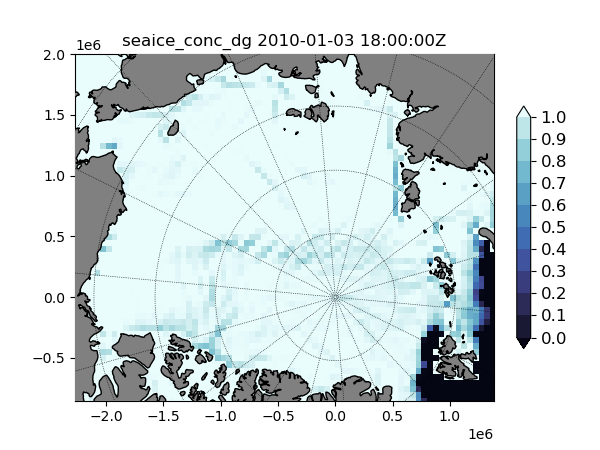

In [11]:
for n in range(ncycle):
    time = c.time_start + n * c.cycle_period * timedelta(hours=1)
    fld = model.read_var(path=model.truth_dir, time=time, name=vname)

    fig, ax = plt.subplots(1,1,figsize=(6,4.5))

    if model.variables[vname]['is_vector']:
        model.grid.plot_field(ax, np.hypot(fld[0], fld[1]), vmin, vmax, cmap=cmap)
        model.grid.plot_vectors(ax, fld)
    else:
        model.grid.plot_field(ax, fld, vmin, vmax, cmap=cmap)
    add_colorbar(fig, ax, cmap, vmin, vmax)
    model.grid.plot_land(ax, color='gray')
    ax.set_title(f"{vname} {time:%Y-%m-%d %H:%M:%SZ}")

    plt.savefig(os.path.join(model.truth_dir, f"{vname}_{time:%Y-%m-%dT%H:%M:%SZ}.png"))
    plt.close()

# show the last image
display(Image(os.path.join(model.truth_dir, f"{vname}_{time:%Y-%m-%dT%H:%M:%SZ}.png")))

In [62]:
# view figures
slider_cycle = widgets.IntSlider(
    value=0,
    min=0,
    max=ncycle-1,
    step=1,
    description='Cycle:',
    continuous_update=False
)
output_cycle = widgets.Output()

def update_plot(n):
    with output_cycle:
        clear_output(wait=True)
        time = c.time_start + n * c.cycle_period * timedelta(hours=1)
        display(Image(filename=os.path.join(model.truth_dir, f"{vname}_{time:%Y-%m-%dT%H:%M:%SZ}.png")))

widgets.interact(update_plot, n=slider_cycle)
display(output_cycle)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Cycle:', max=11), Output()), _d…

Output()

## Ensemble generation

Ensemble forecast is a Monte-Carlo approach to better quantify the model forecast uncertainties.

### Perturbation scheme

Check the `perturb` section in model configuration `nextsim-config.yml` for details.

You can try to change the parameters:

- `amp` (standard deviation of perturbations)
- `hcorr` (horizontal correlation length, in meters)
- `tcorr` (temporal correlation length, in hours)

By default the atmospheric forcing (wind) is perturbed using Evensen 1994 approach to generate ensemble members

In [16]:
# generate ensemble by perturbed runs, test the effect of changing parameters
def generate_init_ens():
    c.time = c.time_start
    os.system("mkdir -p "+c.cycle_dir(c.time))
    # preprocessing, linking files and perturbing boundary forcing files
    scheme.run_step(c, 'preprocess', mpi=False)
    # run ensemble forecast step
    scheme.run_step(c, 'ensemble_forecast', mpi=False)

generate_init_ens()


RUNNING preprocess step
Preprocessing nextsim.dg state:
using restart files in /home/data-nextsim-workshop2025/assimilation/icbc
..................................................| 100% done.
timer: preprocess took 5.820113658905029 seconds

RUNNING ensemble_forecast step
Running nextsim.dg ensemble forecast:
..................................................| 100% done.
timer: ensemble_forecast took 17.657824516296387 seconds


### Visualize the ensemble members

In [ ]:
vname = 'seaice_conc_dg'
k = 0
vmin = 0
vmax = 1
cmap = cmocean.cm.ice

In [ ]:
vname = 'seaice_thick_dg'
k = 0
vmin = 0
vmax = 3
cmap = 'viridis'

In [19]:
vname = 'atmos_surf_velocity'
vmin = 0
vmax = 35
cmap = 'PuBu'

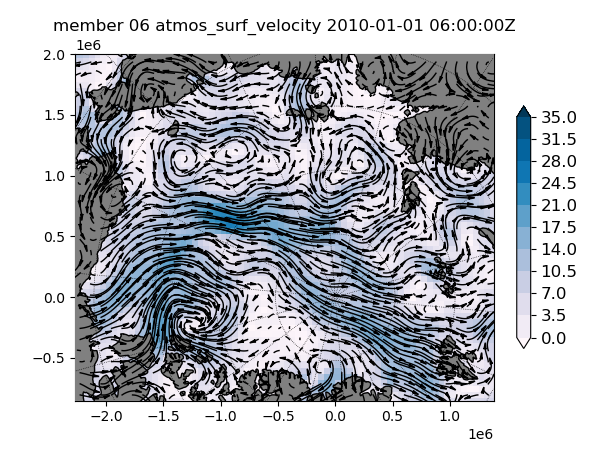

In [20]:
# plot ensemble state for visualization
c.time = c.time_start
path = c.forecast_dir(c.time, 'nextsim.dg')

for mem_id in range(c.nens):
    fld = model.read_var(path=path, time=c.next_time, name=vname, member=mem_id)

    fig, ax = plt.subplots(1,1,figsize=(6,4.5))

    if model.variables[vname]['is_vector']:
        model.grid.plot_field(ax, np.hypot(fld[0], fld[1]), vmin, vmax, cmap=cmap)
        model.grid.plot_vectors(ax, fld)
    else:
        model.grid.plot_field(ax, fld, vmin, vmax, cmap=cmap)
    add_colorbar(fig, ax, cmap, vmin, vmax)
    model.grid.plot_land(ax, color='gray')
    ax.set_title(f"member {mem_id+1:02} {vname} {c.next_time:%Y-%m-%d %H:%M:%SZ}")

    plt.savefig(os.path.join(path, f"mem{mem_id+1:02}_{vname}_{c.next_time:%Y-%m-%dT%H:%M:%SZ}.png"))
    plt.close()

# show the last image
display(Image(os.path.join(path, f"mem{mem_id+1:02}_{vname}_{c.next_time:%Y-%m-%dT%H:%M:%SZ}.png")))

In [21]:
c.time = c.time_start

slider_mem = widgets.IntSlider(
    value=0,
    min=1,
    max=c.nens,
    step=1,
    description='Member:',
    continuous_update=False
)
output_mem = widgets.Output()

def update_plot(mem_id):
    with output_mem:
        clear_output(wait=True)
        path = c.forecast_dir(c.time, 'nextsim.dg')
        time = c.next_time
        display(Image(filename=os.path.join(path, f"mem{mem_id:02}_{vname}_{c.next_time:%Y-%m-%dT%H:%M:%SZ}.png")))

widgets.interact(update_plot, mem_id=slider_mem)
display(output_mem)

interactive(children=(IntSlider(value=1, continuous_update=False, description='Member:', max=6, min=1), Output…

Output()

### Free ensemble run

The following code runs the free ensemble without assimilation,
if you didn't change any setting, this can be skipped (cycle-free is already in the test data)

In [ ]:
# run free ensemble (NoDA) for the entire time period
def run_free_ens():
    c.time = c.time_start
    
    while c.time < c.time_end:
        print(f"\n\033[1;33mCURRENT CYCLE\033[0m: {c.time} => {c.next_time}", flush=True)
        os.system("mkdir -p "+c.cycle_dir(c.time))

        # preprocessing, linking files and perturbing boundary forcing files
        scheme.run_step(c, 'preprocess', mpi=False)

        # run ensemble forecast step
        scheme.run_step(c, 'ensemble_forecast', mpi=False)

        # advance to next cycle
        c.time = c.next_time

run_free_ens()


In [23]:
%%bash

cd /home/data-nextsim-workshop2025/assimilation
rm -rf cycle-free
cp -r cycle cycle-free

### Diagnostic error and ensemble spread



In [24]:
def get_error_stats(path, time, vname):
    """
    Compute error statistics:
    
    Returns:
        domain-averaged rmse of ensemble mean versus truth.
        domain-averaged ensemble spread.
    """
    truth = model.read_var(path=model.truth_dir, time=time, name=vname)

    # ensemble mean state
    mean = np.zeros(c.grid.x.shape)
    for mem_id in range(c.nens):
        mean += model.read_var(path=path, time=time, name=vname, member=mem_id)
    mean /= c.nens

    # ensemble spread
    vari = np.zeros(c.grid.x.shape)
    for mem_id in range(c.nens):
        mem = model.read_var(path=path, time=time, name=vname, member=mem_id)
        vari += (mem - mean)**2
    vari /= c.nens-1

    rmse = np.sqrt(np.nanmean((mean - truth)**2))
    sprd = np.sqrt(np.nanmean(vari))
    return rmse, sprd

def get_error_ts(cycle_dir, vname):
    """
    Compute error and ensemble spread time series
    """
    ts = []
    rmse_ts = []
    sprd_ts = []
    dt = c.cycle_period * timedelta(hours=1)
    for n in range(ncycle):
        time = c.time_start + n * dt
        path = os.path.join(cycle_dir, f'{time:%Y%m%d%H%M}', 'nextsim.dg')

        rmse, sprd = get_error_stats(path, time, vname)
        rmse_ts.append(rmse)
        sprd_ts.append(sprd)
        ts.append(time)
        
        next_time = c.time_start + (n+1) * dt
        rmse, sprd = get_error_stats(path, next_time, vname)
        rmse_ts.append(rmse)
        sprd_ts.append(sprd)
        ts.append(next_time)
    return ts, rmse_ts, sprd_ts

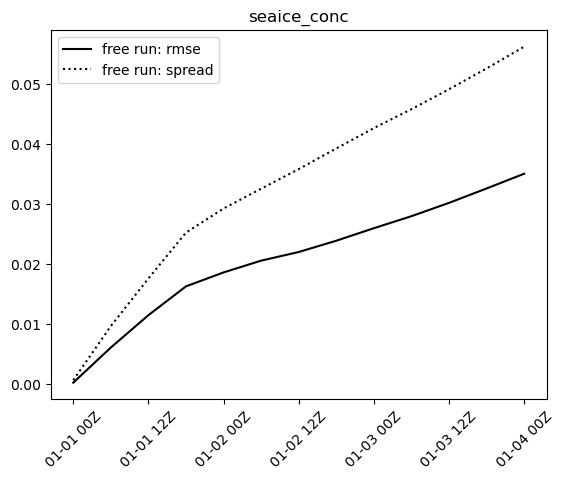

In [25]:
vname = 'seaice_conc'

cycle_dir = "/home/data-nextsim-workshop2025/assimilation/cycle-free"
ts, rmse_ts_free, sprd_ts_free = get_error_ts(cycle_dir, vname)
plt.plot(ts, rmse_ts_free, 'k-', label='free run: rmse')
plt.plot(ts, sprd_ts_free, 'k:', label='free run: spread')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %HZ'))
plt.legend()
plt.title(vname)
plt.xticks(rotation=45);

## Assimilate single observation

It is easier to understand DA by starting with a scalar case, in this section we try to assimilate only 1 seaice_conc observation and see how the EnKF uses this information to correct the model state variables.

### Prepare the experiment

Since we are just assimilating 1 obs, a much larger ensemble size (99) will be used in this case. The large_ens directory contains the restart files for each member already.

In [12]:
workdir = '/home/data-nextsim-workshop2025/assimilation/single-obs'
os.environ['workdir'] = workdir

In [17]:
%%bash

mkdir -p $workdir/cycle/201001020000/nextsim.dg
cd $workdir/cycle/201001020000/nextsim.dg
ln -fs /home/data-nextsim-workshop2025/assimilation/large_ens/* .

In [13]:
# some preparation, use large_ens case for this section
time = datetime(2010, 1, 2, tzinfo=timezone.utc)
c1 = Config(config_file=config_file, nproc=nproc, nens=99, work_dir=workdir, time=time, debug=False, iter=0)

from NEDAS.assim_tools.state import State
state1 = State(c1)

from NEDAS.assim_tools.obs import Obs
obs1 = Obs(c1, state1)

model1 = c1.models['nextsim.dg']

### Create the observation

In [14]:
#define obs location in domain
obs_x = 0.44e6
obs_y = -0.22e6

obs1.obs_seq = {
    'obs': [],
    't': np.array([c.time_analysis_start]),
    'x': np.array([obs_x]),
    'y': np.array([obs_y]),
    'z': np.array([0]),
}

obs_rec_id = 0
obs_rec = obs1.info['records'][obs_rec_id]
obs_rec['nobs'] = 1


In [15]:
# compute obs from truth
# member=None indicates using truth files for synthetic obs
obs1.obs_seq['obs'] = obs1.state_to_obs(c1, state1, 'prior', member=None, **obs_rec, **obs1.obs_seq)

# add perturbation (obs error)
obs_err = obs_rec['err']['std']
obs1.obs_seq['obs'] += np.random.normal(0, 1) * obs_err

obs1.obs_seq

{'obs': array([0.99252749]),
 't': array([datetime.datetime(2010, 1, 2, 0, 0, tzinfo=datetime.timezone.utc)],
       dtype=object),
 'x': array([440000.]),
 'y': array([-220000.]),
 'z': array([0])}

In [18]:
# compute obs_prior from members restart files
for mem_id in range(c1.nens):
    obs1.obs_prior_seq[mem_id, obs_rec_id] = obs1.state_to_obs(c1, state1, 'prior', member=mem_id, **obs_rec, **obs1.obs_seq)

obs_val = obs1.obs_seq['obs'].item()
obs_prior_ens = []
for key, val in obs1.obs_prior_seq.items():
    obs_prior_ens.append(val.item())
obs_prior_ens = np.array(obs_prior_ens)

obs_prior_ens

array([0.91790285, 1.        , 1.        , 0.96598187, 1.        ,
       0.98635284, 0.96599726, 0.94036053, 0.98501218, 0.9987008 ,
       0.90247644, 1.        , 0.91997911, 0.99386418, 0.98883064,
       0.96827161, 0.8992369 , 0.99625909, 0.9653112 , 0.98655552,
       0.98662723, 0.99570692, 0.93542707, 0.99846139, 0.88741456,
       0.92391331, 0.92966289, 0.98383201, 0.94803241, 0.88098134,
       0.86987225, 0.93293489, 0.99167703, 0.91011281, 0.89154641,
       0.94099937, 0.97674856, 0.97177951, 0.92362782, 0.96916294,
       0.98262043, 0.99501804, 0.99749061, 0.98340276, 0.90150387,
       0.95799814, 0.94541955, 0.98848137, 0.91164115, 0.8474629 ,
       0.99110254, 0.99208034, 0.90715748, 0.9677669 , 0.89523412,
       0.83572912, 0.87841943, 0.99183317, 0.86010658, 0.85674549,
       0.988895  , 0.99922621, 0.8172822 , 0.98780406, 1.        ,
       1.        , 0.93679982, 0.97119468, 0.87681843, 0.93158155,
       0.9975104 , 0.95104353, 0.75923271, 0.88692723, 0.91940

### Visualize obs-state error distribution

In [19]:
# pick a model state variable to be updated by the obs
vname = 'seaice_conc_dg'
k = 0  ##dg component
vmin = 0
vmax = 1
cmap = cmocean.cm.ice

In [ ]:
vname = 'seaice_thick_dg'
k = 0  ##dg component
vmin = 0
vmax = 3
cmap = 'viridis'

In [20]:
# compute ensemble covariance between obs and model state
fld_truth = model1.read_var(path=model1.truth_dir, time=c1.time, name=vname, k=k)

path = c1.forecast_dir(c1.time, 'nextsim.dg')

fld_prior_ens = np.zeros((c1.nens,)+c1.grid.x.shape)
for mem_id in range(c1.nens):
    fld_prior_ens[mem_id, ...] = model1.read_var(path=path, member=mem_id, time=c1.time, name=vname, k=k)
fld_prior_mean = np.mean(fld_prior_ens, axis=0)    
obs_prior_mean = np.mean(obs_prior_ens)

cov = np.zeros(c1.grid.x.shape)
fld_prior_var = np.zeros(c1.grid.x.shape)
obs_prior_var = 0
for mem_id in range(c1.nens):
    cov += ((fld_prior_ens[mem_id,...] - fld_prior_mean) * (obs_prior_ens[mem_id] - obs_prior_mean))
    fld_prior_var += (fld_prior_ens[mem_id,...] - fld_prior_mean)**2
    obs_prior_var += (obs_prior_ens[mem_id] - obs_prior_mean)**2
cov /= c1.nens-1
fld_prior_var /= c1.nens-1
obs_prior_var /= c1.nens-1

fld_prior_var[np.where(fld_prior_var==0)] = 1e-10

corr = cov / np.sqrt(fld_prior_var * obs_prior_var)

In [21]:
# sliders to interactively pick i,j state location
i, j = 52, 14
i_slider = widgets.IntSlider(value=i, min=0, max=c1.grid.nx-1, description='i:', orientation='horizontal')
j_slider = widgets.IntSlider(value=j, min=0, max=c1.grid.ny-1, description='j:', orientation='vertical')

def plot_corr_map(i, j):
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))

    # Truth field
    c1.grid.plot_field(ax[0], fld_truth, vmin, vmax, cmap=cmap)
    add_colorbar(fig, ax[0], cmap, vmin, vmax)
    ax[0].set_title(f"Truth: {vname}")
    
    # Correlation map
    c1.grid.plot_field(ax[1], corr, vmin=-1, vmax=1, cmap=cmocean.cm.balance)
    add_colorbar(fig, ax[1], cmocean.cm.balance, -1, 1)
    ax[1].set_title(f"Corr(seaice_conc, {vname})")

    for l in range(2):
        c1.grid.plot_land(ax[l], color='gray')
        ax[l].plot(obs_x, obs_y, 'k.', markersize=10)
        ax[l].plot(c1.grid.x[j, i], c1.grid.y[j, i], 'k+', markersize=10)

    # Scatter plot
    ax[2].scatter(obs_prior_ens, fld_prior_ens[:, j, i], color='c')
    fldmin = min(fld_prior_ens[:, j, i])
    fldmax = max(fld_prior_ens[:, j, i])
    ax[2].plot([obs_val, obs_val], [fldmin, fldmax], 'y', linewidth=3, alpha=0.5)
    ax[2].set_xlabel('Obs: seaice_conc', fontsize=12)
    ax[2].set_ylabel(f'State: {vname} (+)', fontsize=12)
    ax[2].set_title("Obs-state bivariate relation")

    pos = ax[2].get_position()
    ax[2].set_position([pos.x0 + 0.02, pos.y0, pos.width - 0.02, pos.height])
    plt.show()

output_corr = widgets.Output()

def plot(i, j):
    with output_corr:
        plot_corr_map(i, j)

interactive_plot = widgets.interactive_output(plot, {'i': i_slider, 'j': j_slider})

# Layout: vertical j_slider to the left of plot and i_slider above
ui = widgets.VBox([
    i_slider,
    widgets.HBox([
        j_slider,
        output_corr,
    ])
])

display(ui, interactive_plot)

Output()

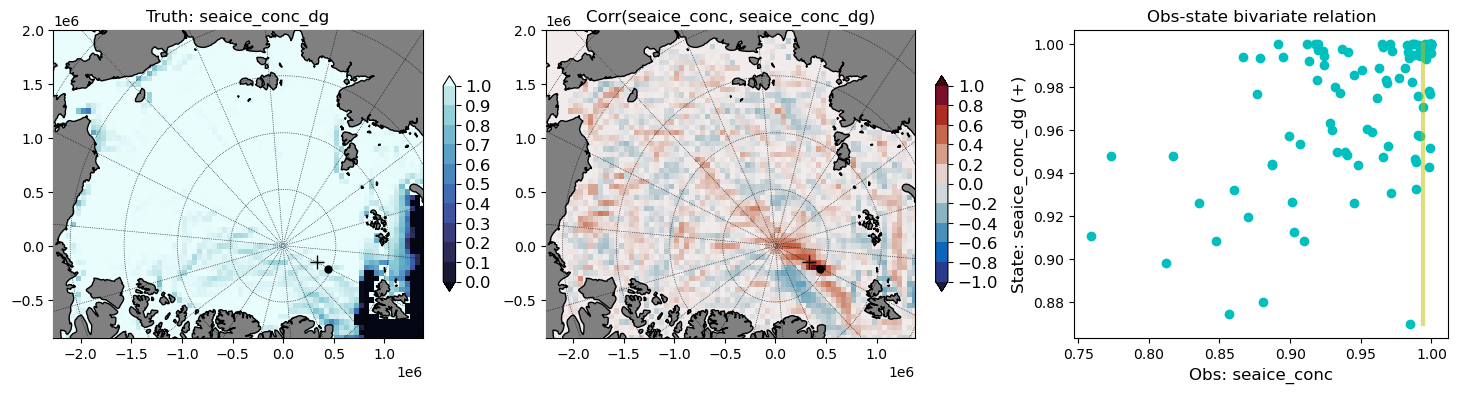

In [55]:
# observation at . position
# state variable at + position
# left: true state; middle: correlation between obs and state; right: bivariate relation between obs and state
plot_corr_map(i, j)

### Analysis with EnKF

We use the Ensemble Adjustment Kalman Filter (EAKF; Anderson 2003) variant of EnKF to compute the increment.

In [22]:
# filter parameters (change them to see their effect)

# specified obs error in computing obs likelihood
obs_err = 0.01 #obs_rec['err']['std']

# localization distance
hroi = 5e5 #obs_rec['hroi']

In [23]:
from NEDAS.assim_tools.assimilators.EAKF.core import obs_increment_eakf, update_ensemble
from NEDAS.assim_tools.localization.distance_based import gaspari_cohn_func

# obs-space analysis increment
obs_incr = obs_increment_eakf(obs_prior_ens, obs_val, obs_err)

# localization factor
fld_dist = c1.grid.distance(obs_x, c1.grid.x, obs_y, c1.grid.y, p=2, type='cartesian')
fld_local_factor = gaspari_cohn_func(fld_dist, hroi)

# update state priors
fld_post_ens = update_ensemble(fld_prior_ens, obs_prior_ens, obs_incr, fld_local_factor)

# update obs priors
obs_post_ens = update_ensemble(obs_prior_ens, obs_prior_ens, obs_incr, 1)

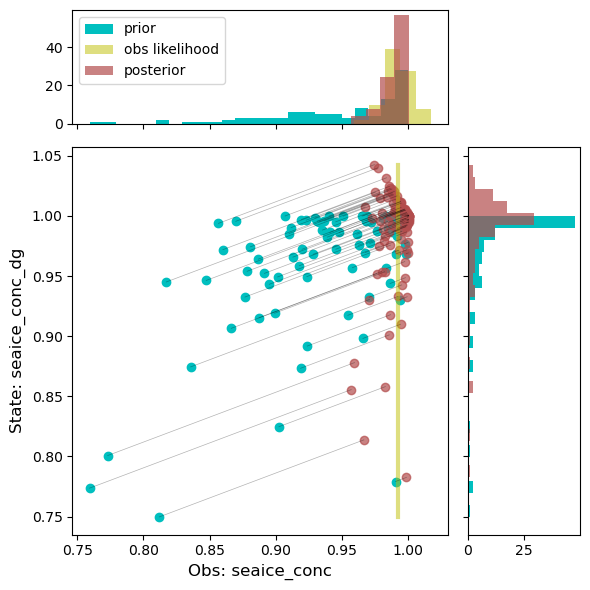

In [24]:
i, j = 52, 13

fig = plt.figure(figsize=(6, 6))

gs = gridspec.GridSpec(4, 4)
ax_scatter = fig.add_subplot(gs[1:4, 0:3])  # main scatter plot
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_scatter)  # x histogram
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_scatter)  # y histogram
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)

prior_bin_color = 'c'
post_bin_color = [.7, .3, .3]
obs_bin_color = 'y'

def plot_histogram(ax, data, bincolor, bin_wd=0.01, alpha=1, orientation='vertical', label=''):
    nbins = int((max(data) - min(data)) / bin_wd)
    ax.hist(data, bins=nbins, color=bincolor, orientation=orientation, density=True, alpha=alpha, label=label) 

# Scatter plot
ax_scatter.scatter(obs_prior_ens, fld_prior_ens[:,j,i], color=prior_bin_color)
fldmin = min(np.hstack([fld_post_ens[:, j, i], fld_prior_ens[:, j, i]]))
fldmax = max(np.hstack([fld_post_ens[:, j, i], fld_prior_ens[:, j, i]]))
ax_scatter.plot([obs_val, obs_val], [fldmin, fldmax], 'y', linewidth=3, alpha=0.5)
ax_scatter.scatter(obs_post_ens, fld_post_ens[:,j,i], color=post_bin_color, alpha=0.7)
ax_scatter.plot(np.array([obs_prior_ens, obs_post_ens]), np.array([fld_prior_ens[:,j,i], fld_post_ens[:,j,i]]), 'k', linewidth=0.5, alpha=0.3)
ax_scatter.set_xlabel("Obs: seaice_conc", fontsize=12)
ax_scatter.set_ylabel(f"State: {vname}", fontsize=12)

# Histogram obs
# prior
plot_histogram(ax_histx, obs_prior_ens, prior_bin_color, label='prior')
# simulate obs likelihood with random sampling
obs_sample = obs_val + obs_err * np.random.normal(0, 1, c1.nens)
plot_histogram(ax_histx, obs_sample, obs_bin_color, alpha=0.5, label='obs likelihood')
# posterior
plot_histogram(ax_histx, obs_post_ens, post_bin_color, alpha=0.7, label='posterior')
ax_histx.legend()

# Histogram state
plot_histogram(ax_histy, fld_prior_ens[:,j,i], prior_bin_color, orientation='horizontal')
plot_histogram(ax_histy, fld_post_ens[:,j,i], post_bin_color, orientation='horizontal', alpha=0.7)

plt.tight_layout()

Text(0.5, 1.0, 'analysis increment seaice_conc_dg, member 1')

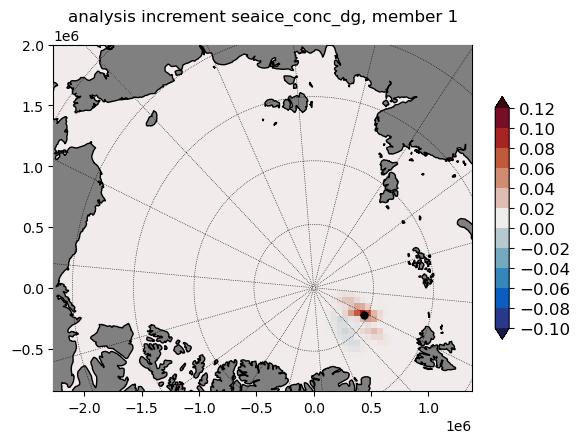

In [25]:
mem_id = 0

vmin_incr = -0.1
vmax_incr = 0.1
cmap_incr = cmocean.cm.balance

fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
c1.grid.plot_field(ax, (fld_post_ens - fld_prior_ens)[mem_id,...], vmin_incr, vmax_incr, cmap=cmap_incr)
add_colorbar(fig, ax, cmap_incr, vmin_incr, vmax_incr)

c1.grid.plot_land(ax, color='gray')
ax.plot(obs_x, obs_y, 'k.', markersize=10)
ax.set_title(f"analysis increment {vname}, member {mem_id+1}")


## Cycling DA

Now we better understand how EnKF works, it is time to test it in a cycling DA experiment.
The time period of interest is divided into analysis cycles, at each cycle:

- Preprocess: link necessary files, add perturbation, other model-specific things
- Run EnKF to assimilate observations and update the restart files
- Postprocess: fix anything not physical due to assimilation
- Run the model forecasts to the next cycle

### Run the experiment

In [41]:
# reload configuration from config.yml
c = Config(config_file=config_file, nproc=nproc, nens=nens, debug=False)

In [42]:
# give this experiment a code name

expt = 'ctrl'
os.environ['expt'] = expt

In [ ]:
##rerun cycling experiment from previous free ens run

def run_analysis():
    c.time = c.time_analysis_start
    while c.time < c.time_end:
        print(f"\n\033[1;33mCURRENT CYCLE\033[0m: {c.time} => {c.next_time}", flush=True)

        # don't need to run scheme.preprocess to link files and perturb again
        # only copy the restart files from previous cycle
        for mem_id in range(c.nens):
            file1 = model.filename(path=c.forecast_dir(c.prev_time, 'nextsim.dg'), member=mem_id, time=c.time) 
            file2 = model.filename(path=c.forecast_dir(c.time, 'nextsim.dg'), member=mem_id, time=c.time)
            os.system(f"cp {file1} {file2}")

        # run data assimilation
        scheme.run_step(c, 'filter', mpi=True)

        # postprocess model variables
        scheme.run_step(c, 'postprocess', mpi=False)

        # ensemble forecast step
        scheme.run_step(c, 'ensemble_forecast', mpi=False)

        # advance to next cycle
        c.time = c.next_time

run_analysis()

### Visualize analysis increments in obs- and state-space

In [72]:
##which time
c.time = datetime(2010, 1, 2, 0, tzinfo=timezone.utc)

##which member to show increments
mem_id = 0

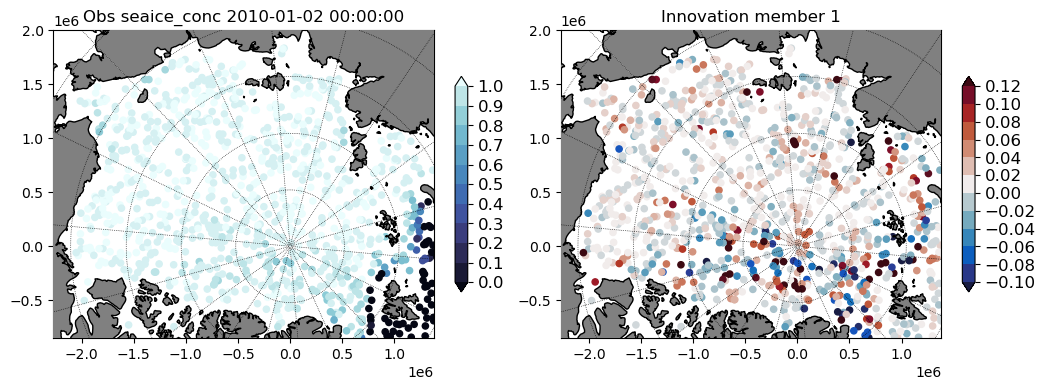

In [74]:
##plot obs network and innovations
##which obs variable to show?
vname = 'seaice_conc'
obs_rec_id = 0
k = 0
vmin = 0
vmax = 1
cmap = cmocean.cm.ice
vmin_diff = -0.1
vmax_diff = 0.1
cmap_diff = cmocean.cm.balance

# obs sequence
seq = np.load(os.path.join(c.analysis_dir(c.time), f"obs_seq.rec{obs_rec_id}.npy"), allow_pickle=True).item()
# obs prior sequence for member
prior_seq = np.load(os.path.join(c.analysis_dir(c.time), f"obs_prior_seq.rec{obs_rec_id}.mem{mem_id:03}.npy"), allow_pickle=True)

fig, ax = plt.subplots(1, 2, figsize=(12,4))

# plot the obs seq
c.grid.plot_scatter(ax[0], seq['obs'], x=seq['x'], y=seq['y'], vmin=vmin, vmax=vmax, cmap=cmap, markersize=20)
add_colorbar(fig, ax[0], cmap, vmin, vmax)
ax[0].set_title(f"Obs {vname} {c.time:%Y-%m-%d %H:%M:%S}")

# plot the innovations
c.grid.plot_scatter(ax[1], seq['obs']-prior_seq, x=seq['x'], y=seq['y'], vmin=vmin_diff, vmax=vmax_diff, cmap=cmap_diff, markersize=20)
add_colorbar(fig, ax[1], cmap_diff, vmin_diff, vmax_diff)
ax[1].set_title(f"Innovation member {mem_id+1}")

for l in range(2):
    c.grid.plot_land(ax[l], color='gray')


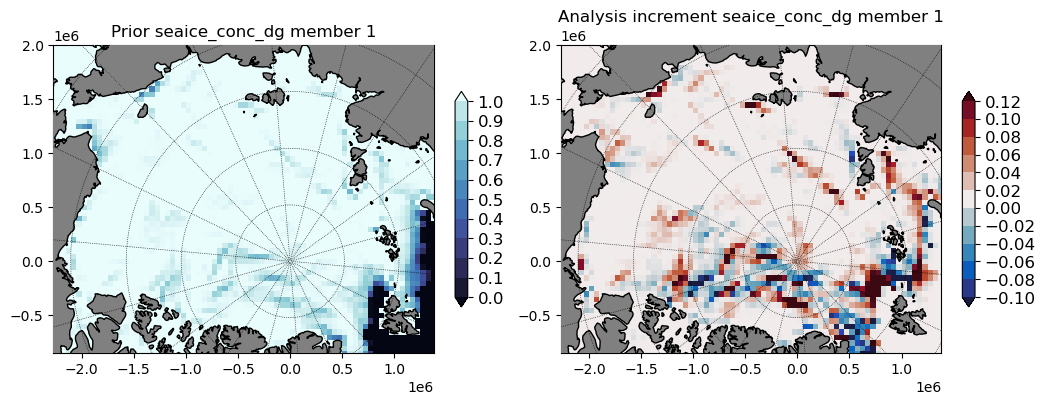

In [75]:
#plot analysis increment

##which state variable to show?
vname = 'seaice_conc_dg'
k = 0
vmin = 0
vmax = 1
cmap = cmocean.cm.ice
vmin_diff = -0.1
vmax_diff = 0.1
cmap_diff = cmocean.cm.balance

# read from model restart files
path = c.forecast_dir(c.prev_time, 'nextsim.dg')
fld0 = model.read_var(path=path, member=mem_id, time=c.time, name=vname, k=k)
path = c.forecast_dir(c.time, 'nextsim.dg')
fld1 = model.read_var(path=path, member=mem_id, time=c.time, name=vname, k=k)

fig, ax = plt.subplots(1, 2, figsize=(12,4))

c.grid.plot_field(ax[0], fld0[...], vmin, vmax, cmap=cmap)
add_colorbar(fig, ax[0], cmap, vmin, vmax)
ax[0].set_title(f"Prior {vname} member {mem_id+1}")

c.grid.plot_field(ax[1], (fld1-fld0)[...], vmin_diff, vmax_diff, cmap=cmap_diff)
add_colorbar(fig, ax[1], cmap_diff, vmin_diff, vmax_diff)
ax[1].set_title(f"Analysis increment {vname} member {mem_id+1}")

for l in range(2):
    c.grid.plot_land(ax[l], color='gray')


### Diagnose error and ensemble spread

In [47]:
%%bash

# make a copy of the work_dir, for comparison later
cd /home/data-nextsim-workshop2025/assimilation
rm -rf cycle-$expt
cp -r cycle cycle-$expt

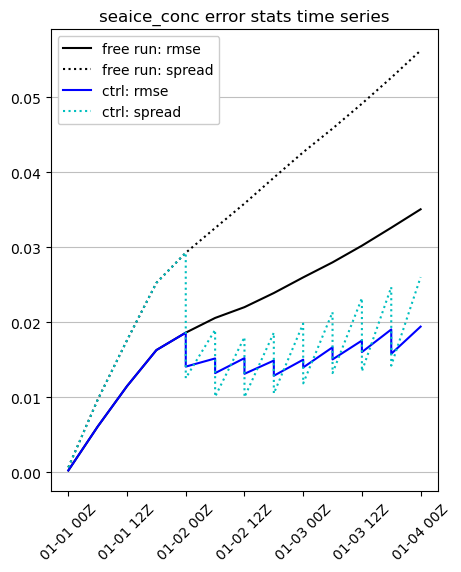

In [48]:
vname = 'seaice_conc'

plt.figure(figsize=(5,6))

# free run
cycle_dir = "/home/data-nextsim-workshop2025/assimilation/cycle-free"
ts, rmse_ts_free, sprd_ts_free = get_error_ts(cycle_dir, vname)
plt.plot(ts, rmse_ts_free, 'k-', label='free run: rmse')
plt.plot(ts, sprd_ts_free, 'k:', label='free run: spread')

# from the experiment
cycle_dir = f"/home/data-nextsim-workshop2025/assimilation/cycle-{expt}"
ts, rmse_ts, sprd_ts = get_error_ts(cycle_dir, vname)
plt.plot(ts, rmse_ts, 'b-', label=f'{expt}: rmse')
plt.plot(ts, sprd_ts, 'c:', label=f'{expt}: spread')

# add annotation
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %HZ'))
plt.grid(axis='y', color='gray', alpha=0.5)
plt.legend(framealpha=1.0)
plt.title(f"{vname} error stats time series")
_ = plt.xticks(rotation=45)

plt.savefig(os.path.join("plots", f"case_{expt}_{vname}.png"))


Comparison of a few example cases using different filter parameters:

- `ctrl`: control setting in `config-ctrl.yml`
- `large-roi`: localization radius of influence (roi) is increased 10x, causing ensemble spread collapsing too much.
- `adapt-inf`: increase roi and turning on adaptive inflation after assimilation.
- `etkf`: using a different EnKF variant, has different response to same roi.


In [29]:
# cases to be compared
expts = ['ctrl', 'large-roi', 'adapt-inf', 'etkf']

# show the error stats ts plots side by side
vname = 'seaice_conc'
html = '<div style="display: flex; gap: 10px;">'
for expt in expts:
    file = os.path.join("plots", f"case_{expt}_{vname}.png")
    html += f'<img src="{file}" style="max-height:400px;">'
html += '</div>'
display(HTML(html))

vname = 'seaice_thick'
html = '<div style="display: flex; gap: 10px;">'
for expt in expts:
    file = os.path.join("plots", f"case_{expt}_{vname}.png")
    html += f'<img src="{file}" style="max-height:400px;">'
html += '</div>'
display(HTML(html))